## Setup

In [ ]:
!pip install -q ml_collections
!pip install -q transformers

In [ ]:
# Backbone
!wget https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth -q

# Linear layer
!wget https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_linearweights.pth -q

In [ ]:
import torch

In [ ]:
backbone_state_dict = torch.load(
    "dino_vitbase16_pretrain.pth", map_location=torch.device("cpu")
)
linear_layer_state_dict = torch.load(
    "dino_vitbase16_linearweights.pth", map_location=torch.device("cpu")
)["state_dict"]

In [ ]:
backbone_state_dict.update(linear_layer_state_dict)
backbone_state_dict["head.weight"] = backbone_state_dict.pop("module.linear.weight")
backbone_state_dict["head.bias"] = backbone_state_dict.pop("module.linear.bias")

In [ ]:
!git clone https://github.com/abhilashreddys/Explaining-Vision-Transformers.git

Cloning into 'Explaining-Vision-Transformers'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 43 (delta 11), reused 32 (delta 2), pack-reused 0
Unpacking objects: 100% (43/43), done.


## Explaining Vision Transformers

In [ ]:
import sys

sys.path.append("Explaining-Vision-Transformers")

from vit.vit_models import ViTClassifier
from vit.model_configs import base_config
from utils import helpers
from vit.layers import mha

from transformers.tf_utils import shape_list
from tensorflow import keras
import tensorflow as tf
import ml_collections

In [ ]:
class ViTDINOBase(ViTClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def interpolate_pos(self, x, N, h, w):
        class_pos_embed = self.positional_embedding[:, 0]
        patch_pos_embed = self.positional_embedding[:, 1:]
        dim = shape_list(x)[-1]

        # Calculate the resolution to which we need to perform interpolation.
        h0 = h // self.config.patch_size
        w0 = w // self.config.patch_size

        sqrt_N = tf.math.sqrt(tf.cast(N, "float32"))
        sqrt_N_ceil = tf.cast(tf.math.ceil(sqrt_N), "int32")
        patch_pos_embed = tf.reshape(
            patch_pos_embed, (1, sqrt_N_ceil, sqrt_N_ceil, dim)
        )
        patch_pos_embed = tf.image.resize(patch_pos_embed, (h0, w0), method="bicubic")

        tf.debugging.assert_equal(h0, shape_list(patch_pos_embed)[1])
        tf.debugging.assert_equal(w0, shape_list(patch_pos_embed)[2])

        patch_pos_embed = tf.reshape(patch_pos_embed, (1, -1, dim))
        return tf.concat([class_pos_embed[None, ...], patch_pos_embed], axis=1)

    def interpolate_pos_embedding(self, x, h, w):
        """Resizes the positional embedding in case there is a mismatch in resolution.
        E.g., using 480x480 images instead of 224x224 for a given patch size.
        """
        num_patches = shape_list(x)[1] - 1  # Exlcuding the cls token.
        N = shape_list(self.positional_embedding)[1] - 1

        # Segregate the cls embedding from the position embeddings.
        class_pos_embed = self.positional_embedding[:, 0]
        patch_pos_embed = self.positional_embedding[:, 1:]
        dim = shape_list(x)[-1]

        pos_embed = tf.cond(
            tf.logical_and(tf.equal(num_patches, N), tf.equal(h, w)),
            lambda: self.positional_embedding,
            lambda: self.interpolate_pos(x, N, h, w),
        )
        return pos_embed

    def call(self, inputs, training):
        n, h, w, c = shape_list(inputs)
        projected_patches = self.projection(inputs)

        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        if cls_token.dtype != projected_patches.dtype:
            cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Fetch positional embeddings.
        positional_embedding = self.interpolate_pos_embedding(projected_patches, h, w)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Initialize a dictionary to store attention scores from each transformer
        # block.
        attention_scores = dict()

        for transformer_module in self.transformer_blocks:
            encoded_patches, attention_score = transformer_module(encoded_patches)
            attention_scores[f"{transformer_module.name}_att"] = attention_score

        representation = self.layer_norm(encoded_patches)

        encoded_patches = representation[:, 0]
        encoded_patches_exp = tf.expand_dims(encoded_patches, -1)
        avg_patch_tokens = tf.reduce_mean(representation[:, 1:], 1)
        avg_patch_tokens = tf.expand_dims(avg_patch_tokens, -1)
        output = tf.concat([encoded_patches_exp, avg_patch_tokens], -1)
        output = tf.reshape(output, (n, -1))

        # Classification head.
        output = self.head(output)

        if training:
            return output
        else:
            return output, attention_scores

In [ ]:
config = base_config.get_config(model_name="vit_base", projection_dim=768, num_heads=12)

vit_dino_base = ViTDINOBase(config)

dummy_inputs = tf.random.normal((2, 224, 224, 3))
outputs, attn_scores = vit_dino_base(dummy_inputs)

keys = list(attn_scores.keys())
print(attn_scores[keys[-1]].shape)

(2, 12, 197, 197)


In [ ]:
pt_model_dict = {k: backbone_state_dict[k].numpy() for k in backbone_state_dict}

In [ ]:
vit_dino_base.layers[0].layers[0] = helpers.modify_tf_block(
    vit_dino_base.layers[0].layers[0],
    pt_model_dict["patch_embed.proj.weight"],
    pt_model_dict["patch_embed.proj.bias"],
)

# Positional embedding.
vit_dino_base.positional_embedding.assign(tf.Variable(pt_model_dict["pos_embed"]))
vit_dino_base.cls_token.assign(tf.Variable(pt_model_dict["cls_token"]))

# Layer norm layers.
ln_idx = -2
vit_dino_base.layers[ln_idx] = helpers.modify_tf_block(
    vit_dino_base.layers[ln_idx],
    pt_model_dict["norm.weight"],
    pt_model_dict["norm.bias"],
)

# Head layers.
head_layer = vit_dino_base.get_layer("classification_head")
vit_dino_base.layers[-1] = helpers.modify_tf_block(
    head_layer,
    pt_model_dict["head.weight"],
    pt_model_dict["head.bias"],
)

# Transformer blocks.
idx = 0

for outer_layer in vit_dino_base.layers:
    if isinstance(outer_layer, tf.keras.Model) and outer_layer.name != "projection":
        tf_block = vit_dino_base.get_layer(outer_layer.name)
        pt_block_name = f"blocks.{idx}"

        # LayerNorm layers.
        layer_norm_idx = 1
        for layer in tf_block.layers:
            if isinstance(layer, tf.keras.layers.LayerNormalization):
                layer_norm_pt_prefix = f"{pt_block_name}.norm{layer_norm_idx}"
                layer.gamma.assign(
                    tf.Variable(pt_model_dict[f"{layer_norm_pt_prefix}.weight"])
                )
                layer.beta.assign(
                    tf.Variable(pt_model_dict[f"{layer_norm_pt_prefix}.bias"])
                )
                layer_norm_idx += 1

        # FFN layers.
        ffn_layer_idx = 1
        for layer in tf_block.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                dense_layer_pt_prefix = f"{pt_block_name}.mlp.fc{ffn_layer_idx}"
                layer = helpers.modify_tf_block(
                    layer,
                    pt_model_dict[f"{dense_layer_pt_prefix}.weight"],
                    pt_model_dict[f"{dense_layer_pt_prefix}.bias"],
                )
                ffn_layer_idx += 1

        # Attention layer.
        for layer in tf_block.layers:
            (q_w, k_w, v_w), (q_b, k_b, v_b) = helpers.get_tf_qkv(
                f"{pt_block_name}.attn",
                pt_model_dict,
                config,
            )

            if isinstance(layer, mha.TFViTAttention):
                # Key
                layer.self_attention.key = helpers.modify_tf_block(
                    layer.self_attention.key,
                    k_w,
                    k_b,
                    is_attn=True,
                )
                # Query
                layer.self_attention.query = helpers.modify_tf_block(
                    layer.self_attention.query,
                    q_w,
                    q_b,
                    is_attn=True,
                )
                # Value
                layer.self_attention.value = helpers.modify_tf_block(
                    layer.self_attention.value,
                    v_w,
                    v_b,
                    is_attn=True,
                )
                # Final dense projection
                layer.dense_output.dense = helpers.modify_tf_block(
                    layer.dense_output.dense,
                    pt_model_dict[f"{pt_block_name}.attn.proj.weight"],
                    pt_model_dict[f"{pt_block_name}.attn.proj.bias"],
                )

        idx += 1

In [ ]:
import os 
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from PIL import Image

In [ ]:
FOURCC = {
    "mp4": cv2.VideoWriter_fourcc(*"MP4V"),
    "avi": cv2.VideoWriter_fourcc(*"XVID"),
}

In [ ]:
class VideoGeneratorTF:
    def __init__(self, args):
        self.args = args

        self.norm_layer = keras.layers.Normalization(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
        )

    def run(self):
        if self.args.input_path is None:
            print(f"Provided input path {self.args.input_path} is non valid.")
            sys.exit(1)
        else:
            if self.args.video_only:
                self._generate_video_from_images(
                    self.args.input_path, self.args.output_path
                )
            else:
                # If input path exists
                if os.path.exists(self.args.input_path):
                    # If input is a video file
                    if os.path.isfile(self.args.input_path):
                        frames_folder = os.path.join(self.args.output_path, "frames-tf")
                        attention_folder = os.path.join(
                            self.args.output_path, "attention-tf"
                        )

                        os.makedirs(frames_folder, exist_ok=True)
                        os.makedirs(attention_folder, exist_ok=True)

                        self._extract_frames_from_video(
                            self.args.input_path, frames_folder
                        )

                        self._inference(
                            frames_folder,
                            attention_folder,
                        )

                        self._generate_video_from_images(
                            attention_folder, self.args.output_path
                        )

                    # If input is a folder of already extracted frames
                    if os.path.isdir(self.args.input_path):
                        attention_folder = os.path.join(
                            self.args.output_path, "attention-tf"
                        )

                        os.makedirs(attention_folder, exist_ok=True)

                        self._inference(self.args.input_path, attention_folder)

                        self._generate_video_from_images(
                            attention_folder, self.args.output_path
                        )

                # If input path doesn't exists
                else:
                    print(f"Provided input path {self.args.input_path} doesn't exists.")
                    sys.exit(1)

    def _extract_frames_from_video(self, inp: str, out: str):
        vidcap = cv2.VideoCapture(inp)
        self.args.fps = vidcap.get(cv2.CAP_PROP_FPS)

        print(f"Video: {inp} ({self.args.fps} fps)")
        print(f"Extracting frames to {out}")

        success, image = vidcap.read()
        count = 0
        while success:
            cv2.imwrite(
                os.path.join(out, f"frame-{count:04}.jpg"),
                image,
            )
            success, image = vidcap.read()
            count += 1

    def _generate_video_from_images(self, inp: str, out: str):
        img_array = []
        attention_images_list = sorted(glob.glob(os.path.join(inp, "attn-*.jpg")))

        # Get size of the first image
        with open(attention_images_list[0], "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            size = (img.width, img.height)
            img_array.append(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

        print(f"Generating video {size} to {out}")

        for filename in tqdm(attention_images_list[1:]):
            with open(filename, "rb") as f:
                img = Image.open(f)
                img = img.convert("RGB")
                img_array.append(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

        out = cv2.VideoWriter(
            os.path.join(out, "video-tf." + self.args.video_format),
            FOURCC[self.args.video_format],
            self.args.fps,
            size,
        )

        for i in range(len(img_array)):
            out.write(img_array[i])
        out.release()
        print("Done")

    def _preprocess_image(self, image: Image, size: int):
        image = np.array(image)
        image_resized = tf.expand_dims(image, 0)
        shape = tf.cast(tf.shape(image_resized)[1:-1], tf.float32)
        short_dim = min(shape)
        scale = size / short_dim
        new_shape = tf.cast(shape * scale, tf.int32)
        image_resized = tf.image.resize(
            image_resized,
            new_shape,
        )
        return self.norm_layer(image_resized).numpy()

    def _inference(self, inp: str, out: str):
        print(f"Generating attention images to {out}")

        for img_path in tqdm(sorted(glob.glob(os.path.join(inp, "*.jpg")))):
            with open(img_path, "rb") as f:
                img = Image.open(f)
                img = img.convert("RGB")

            preprocessed_image = self._preprocess_image(img, self.args.resize)
            h, w = (
                preprocessed_image.shape[1]
                - preprocessed_image.shape[1] % self.args.patch_size,
                preprocessed_image.shape[2]
                - preprocessed_image.shape[2] % self.args.patch_size,
            )
            preprocessed_image = preprocessed_image[:, :h, :w, :]

            h_featmap = preprocessed_image.shape[1] // self.args.patch_size
            w_featmap = preprocessed_image.shape[2] // self.args.patch_size

            logits, attention_score_dict = self.args.model(
                preprocessed_image, training=False
            )
            attentions = attention_score_dict["transformer_block_11_att"].numpy()

            nh = attentions.shape[1]  # number of head

            # we keep only the output patch attention
            attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
            attentions = attentions.reshape(nh, h_featmap, w_featmap)
            attentions = attentions.transpose((1, 2, 0))

            # interpolation
            attentions = tf.image.resize(
                attentions,
                size=(
                    h_featmap * self.args.patch_size,
                    w_featmap * self.args.patch_size,
                ),
            )

            # save attentions heatmaps
            fname = os.path.join(out, "attn-" + os.path.basename(img_path))
            plt.imsave(
                fname=fname,
                arr=sum(
                    attentions[..., i] * 1 / attentions.shape[-1]
                    for i in range(attentions.shape[-1])
                ),
                cmap="inferno",
                format="jpg",
            )

## Attention Heatmap Output

In [ ]:
# Get demo videos.
!gdown --id 12KScLSdZS5gNvLqoZBenbYeTPaVx4wMj
!gdown --id 1dnPP0QvJ2944GaSE47yMgrt3T0yO4R_R

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=12KScLSdZS5gNvLqoZBenbYeTPaVx4wMj
To: /content/dog.mp4
100% 12.8M/12.8M [00:00<00:00, 156MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dnPP0QvJ2944GaSE47yMgrt3T0yO4R_R
To: /content/dino.mp4
100% 2.18M/2.18M [00:00<00:00, 178MB/s]


In [ ]:
args = ml_collections.ConfigDict()

args.model = vit_dino_base
args.patch_size = 16
args.input_path = "dino.mp4"
args.output_path = "./"
args.resize = 512
args.video_only = False
args.fps = 30.0
args.video_format = "mp4"

In [ ]:
vg = VideoGeneratorTF(args)
vg.run()

Video: dino.mp4 (25.0 fps)
Extracting frames to ./frames-tf
Generating attention images to ./attention-tf


100%|██████████| 278/278 [01:23<00:00,  3.31it/s]


Generating video (896, 512) to ./


100%|██████████| 277/277 [00:01<00:00, 157.45it/s]


Done


In [ ]:
args = ml_collections.ConfigDict()

args.model = vit_dino_base
args.patch_size = 16
args.input_path = "dog.mp4"
args.output_path = "./"
args.resize = 512
args.video_only = False
args.fps = 30.0
args.video_format = "mp4"

In [ ]:
vg = VideoGeneratorTF(args)
vg.run()

Video: dog.mp4 (29.97002997002997 fps)
Extracting frames to ./frames-tf
Generating attention images to ./attention-tf


100%|██████████| 150/150 [01:16<00:00,  1.97it/s]


Generating video (896, 512) to ./


100%|██████████| 149/149 [00:01<00:00, 135.83it/s]


Done


## Attention heatmaps from each head

In [1]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [4]:
RESOLUTION = 224
PATCH_SIZE = 16

In [5]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    if model_type == "original_vit":
        image = rescale_layer(image)

    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)
    
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()

In [6]:
def load_image_from_url(url, model_type):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

In [7]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model

In [8]:
# Load the model.
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

Downloading...
From: https://drive.google.com/uc?id=16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN
To: /content/vit_dino_base16.zip
100%|██████████| 326M/326M [00:02<00:00, 117MB/s] 


Model loaded.


In [11]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1
    num_heads = 12

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

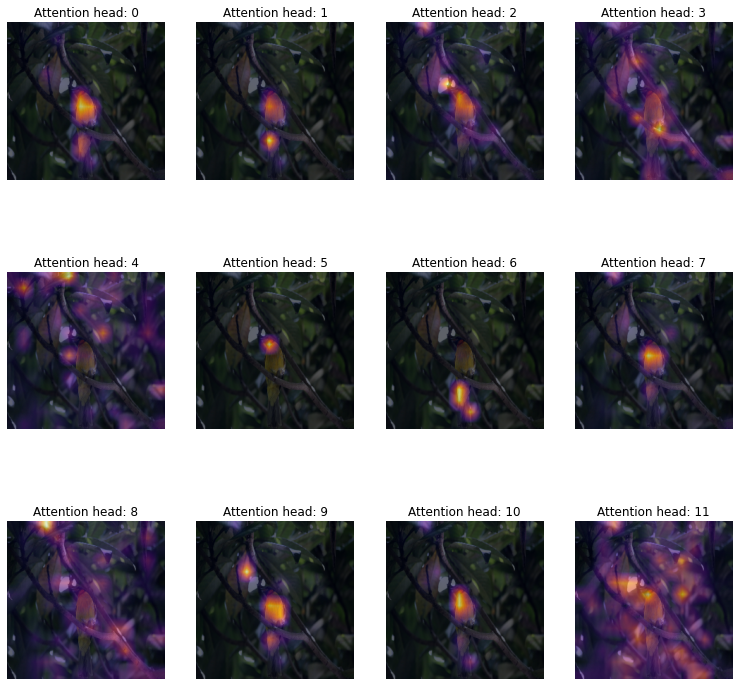

In [12]:
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

## Visualizing the learned projection filters


In [13]:
vit_base_i21k_patch16_224 = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")

Downloading...
From: https://drive.google.com/uc?id=1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ
To: /content/vit_b16_patch16_224.zip
100%|██████████| 322M/322M [00:01<00:00, 165MB/s]


In [14]:
# Extract the projections.
projections = (
    vit_base_i21k_patch16_224.layers[1]
    .get_layer("projection")
    .get_layer("conv_projection")
    .kernel.numpy()
)
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]

# Scale the projections.
scaled_projections = MinMaxScaler().fit_transform(
    projections.reshape(-1, projection_dim)
)

# Reshape the scaled projections so that the leading
scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

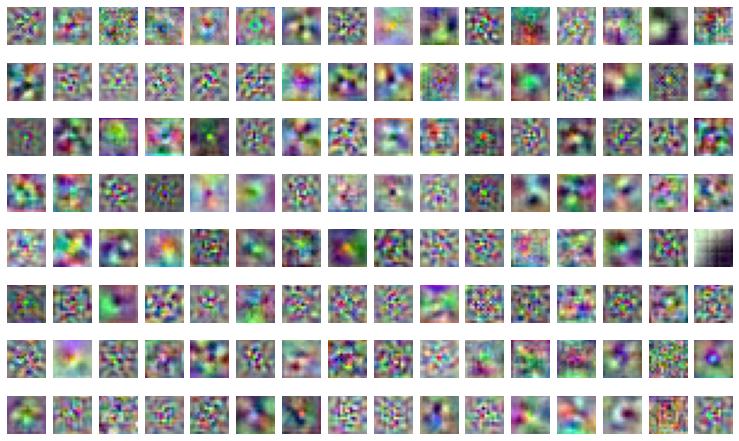

In [18]:
fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.savefig('filters.jpg',dpi=300)

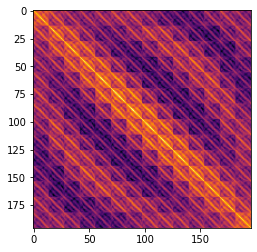

In [16]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()